In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('data_cleaned.csv', sep=';')

### Подход к анализу и решению

В Европе всего лишь 13 записей, когда пассажир остался недоволен переплатой. Поэтому эксплораторный проводился на неевропейских поездках. Нельзя просто так анализировать вместе два разных рынка. Но так как в Европе такое малое число жалоб, то европейские данные будут сопоставляться с остальными.

In [3]:
pd.DataFrame(df.groupby('eu_indicator').overpaid_ride_ticket.value_counts())

overpaid_ride_ticket
eu_indicator overpaid_ride_ticket                      
0            0                                     1386
             1                                      296
1            0                                     2471
             1                                       13

In [4]:
cnt_target = pd.DataFrame(df.groupby('eu_indicator').overpaid_ride_ticket.value_counts()).unstack('overpaid_ride_ticket')

In [5]:
cnt_target.columns = cnt_target.columns.droplevel(0)

In [6]:
cnt_target = cnt_target.rename(columns={0: "False", 1: "True"}, index={1: "True", 0: "False"})

In [7]:
cnt_target

overpaid_ride_ticket,False,True
eu_indicator,,
False,1386,296
True,2471,13


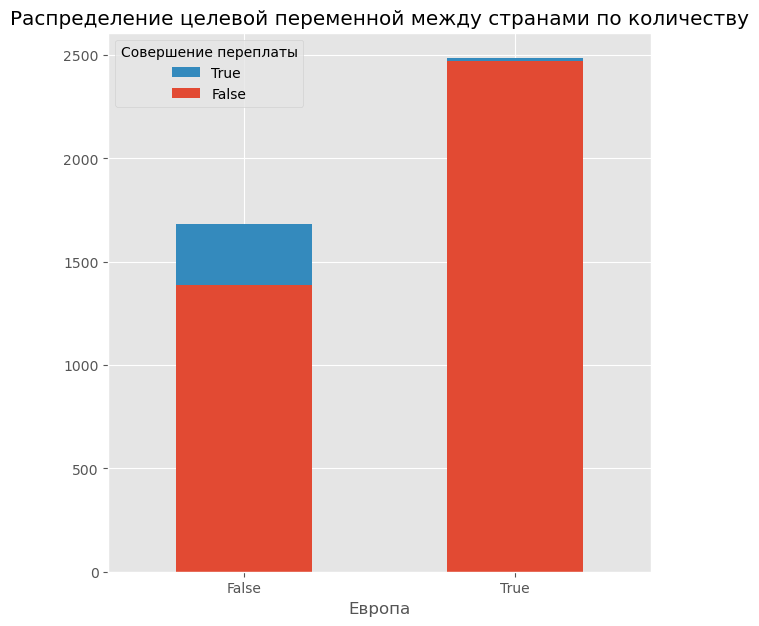

In [8]:
ax = cnt_target.plot.bar(stacked=True, figsize=(7, 7))
handles, labels = plt.gca().get_legend_handles_labels()

order = [1, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='Совершение переплаты')

plt.xlabel('Европа')
plt.title('Распределение целевой переменной между странами по количеству')
plt.xticks(rotation=0)
plt.show()

## Разные аспекты одной проблемы в неевропейской стране

### Большой разброс в разнице между подсчитанной дистанцией и настоящей.

In [9]:
non_eu = df[df.eu_indicator == 0]

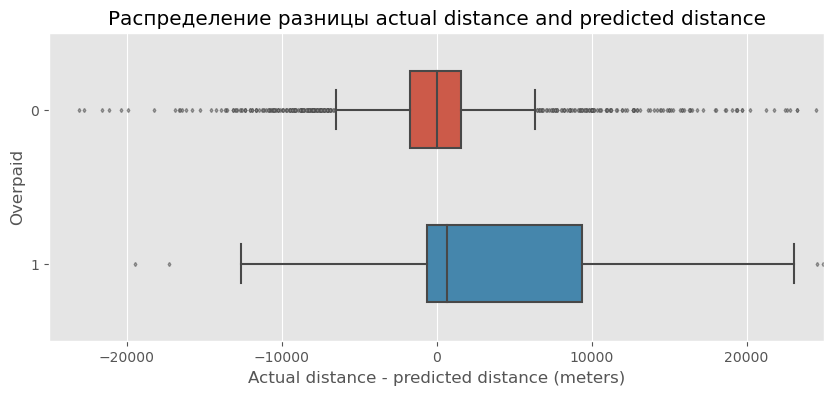

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
flierprops = dict(markerfacecolor='0.75', markersize=2,
              linestyle='none', alpha=.6)
sns.boxplot(data=non_eu, y='overpaid_ride_ticket', x='over_distance', orient='h', width=.5, ax=ax, flierprops=flierprops)
plt.title('Распределение разницы actual distance and predicted distance')
plt.ylabel('Overpaid')
plt.xlabel('Actual distance - predicted distance (meters)')
ax.set_xlim([-25000, 25000])
plt.show()

Несмотря на то, что медианные значения между группами несильно различаются, видна большая разница между IQR, который характеризует разброс данных. 

### Тип определения цены

Интересно заметить, что в Европе не используется система предсказания цены поездки во время самой поездки. Тогда как в неевропейской стране предсказание цены в пути является доминирующим способом определения цены.

Европа

In [11]:
df[df.eu_indicator == 1].prediction_price_type.value_counts()

upfront                        2295
upfront_destination_changed     166
upfront_waypoint_changed          3
prediction                        1
Name: prediction_price_type, dtype: int64

Неевропейский регион

In [12]:
df[df.eu_indicator == 0].prediction_price_type.value_counts()

prediction                     997
upfront                        672
upfront_destination_changed     13
Name: prediction_price_type, dtype: int64

### Насколько люди огорчаются при разных типах определения цены

In [13]:
df[df.eu_indicator == 0].groupby('prediction_price_type').overpaid_ride_ticket.value_counts(normalize=True).round(2)

prediction_price_type        overpaid_ride_ticket
prediction                   0                       0.80
                             1                       0.20
upfront                      0                       0.87
                             1                       0.13
upfront_destination_changed  0                       0.77
                             1                       0.23
Name: overpaid_ride_ticket, dtype: float64

В неевропейском регионе люди чаще сообщают о переплате, если цена поездки предсказывалась во время поездки (prediction), чем заранее (upfront).

### Слабая корреляция между актуальной ценой и предсказанной при цене, указываемой заранее (upfront)

Когда в неевропейских поездках используется определение цены до поездки, наблюдается низкая корреляция с итоговой ценой.

In [14]:
df[df.eu_indicator == 0].corr()['upfront_price']['metered_price'].round(2)

0.23

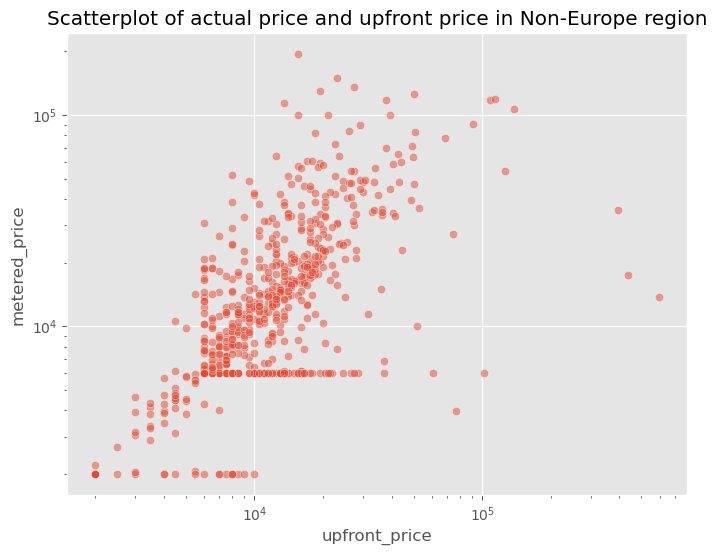

In [15]:
plt.figure(figsize = (8, 6))
plt.xscale('log')
plt.yscale('log')
sns.scatterplot(data=df[df.eu_indicator == 0], x='upfront_price', y='metered_price', alpha=.5)
plt.title('Scatterplot of actual price and upfront price in Non-Europe region')
plt.show()

Возможно, цена часто по-умолчанию выставляется шаблонно низкой, но потом эта цена увеличивается. Один из тревожных сигналов - цена, которая выставляется заранее, плохо характеризует финальную цену. То есть функционально она является результатом предсказания на основе дистанции.

В то время, как в Европе корреляция очень высокая. И она значительно стабильней по сравнению с неевропейским регионом.

In [16]:
df[df.eu_indicator == 1].corr()['upfront_price']['metered_price'].round(2)

0.9

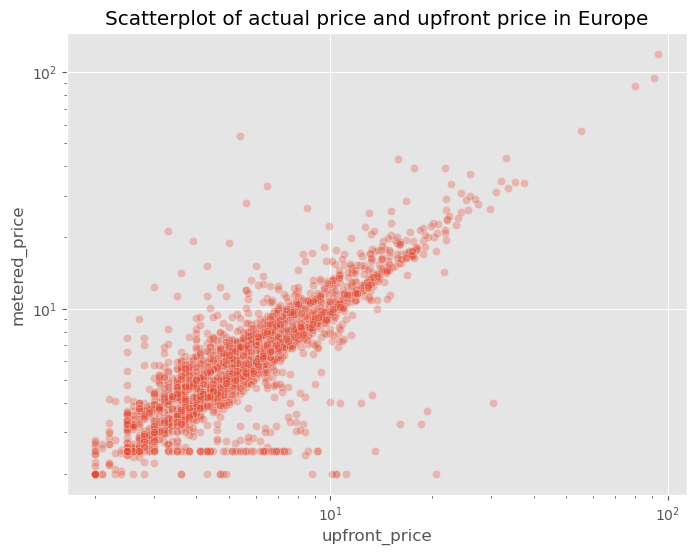

In [17]:
plt.figure(figsize = (8, 6))
plt.xscale('log')
plt.yscale('log')
sns.scatterplot(data=df[df.eu_indicator == 1], x='upfront_price', y='metered_price', alpha=.3)
plt.title('Scatterplot of actual price and upfront price in Europe')
plt.show()

### Слабая корреляция между длительностью поездки и ценой

Сравнение с Европой

In [18]:
cor_cols = ['metered_price', 'upfront_price', 'distance', 'duration', 'gps_confidence', 'predicted_distance', 'predicted_duration']

Корреляция Пирсона между длительностью и дистанцией в Европе .76, в неевропейских поездках - .46

In [19]:
df[df.eu_indicator == 0][cor_cols].corr().round(2)['duration']['distance']

0.46

In [20]:
df[df.eu_indicator == 1][cor_cols].corr().round(2)['duration']['distance']

0.76

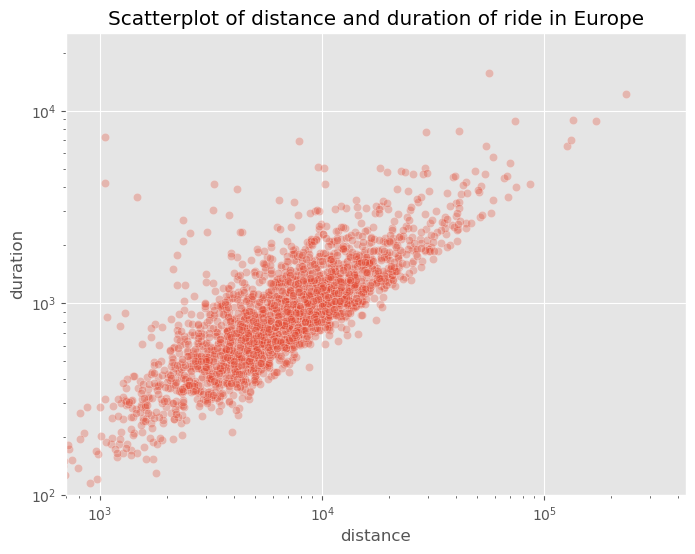

In [21]:
plt.figure(figsize = (8, 6))
plt.xscale('log')
plt.yscale('log')
sns.scatterplot(data=df[df.eu_indicator == 1], x='distance', y='duration', alpha=.3)
plt.xlim(700)
plt.ylim(100)
plt.title('Scatterplot of distance and duration of ride in Europe')
plt.show()

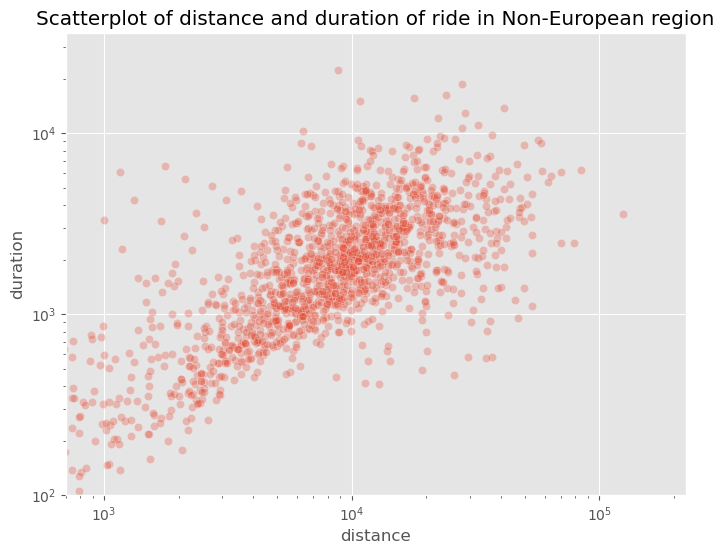

In [22]:
plt.figure(figsize = (8, 6))
plt.xscale('log')
plt.yscale('log')
sns.scatterplot(data=df[df.eu_indicator == 0], x='distance', y='duration', alpha=.3)
plt.xlim(700)
plt.ylim(100)
plt.title('Scatterplot of distance and duration of ride in Non-European region')
plt.show()

Можно заметить сильную гетероскедастичность - при увеличении дистанции сильно увеличивается разброс длительности поездки.

Это нам может говорить о:
- Разных условиях в длительных поездках. К примеру, кто-то стоит долгое время в пробке в центре города. Другой может быстро перемещаться между городами. В таком случае для дальнейшего анализа мог бы быть полезен кластерный анализ поездок.
- Некорректном определении дистанции, если водители хотят её завысить любой ценой.

### Слабое GPS соединение

In [23]:
gps_df = df.groupby('eu_indicator').gps_confidence.value_counts(normalize=True).unstack('gps_confidence')[[1, 0]]

<Figure size 800x600 with 0 Axes>

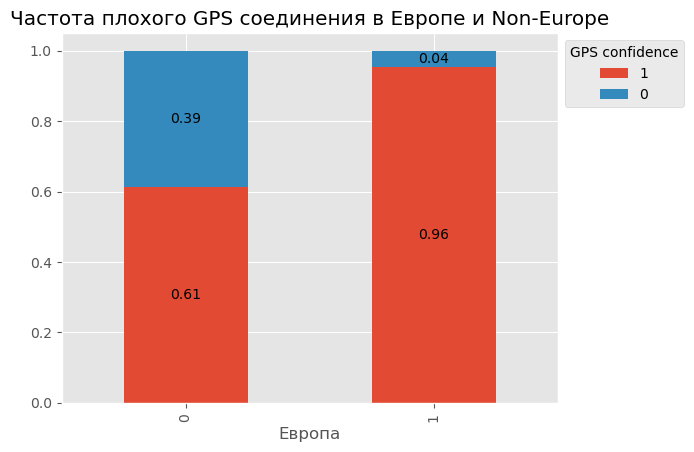

In [24]:
plt.figure(figsize = (8, 6))
ax = gps_df.plot.bar(stacked=True)
for c in ax.containers:
    ax.bar_label(c, label_type='center', fmt='%.2f')

plt.xlabel('Европа')
plt.title('Частота плохого GPS соединения в Европе и Non-Europe')
plt.legend(title='GPS confidence', bbox_to_anchor=(1,1))
plt.show()

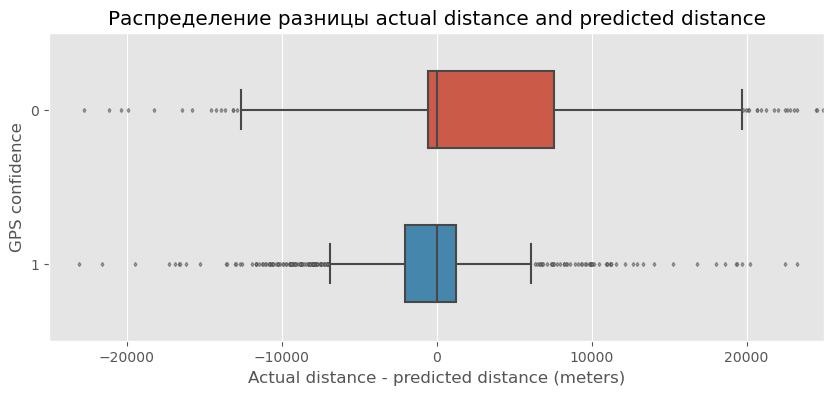

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
flierprops = dict(markerfacecolor='0.75', markersize=2,
              linestyle='none', alpha=.6)
sns.boxplot(data=non_eu, y='gps_confidence', x='over_distance', orient='h', width=.5, ax=ax, flierprops=flierprops)
plt.title('Распределение разницы actual distance and predicted distance')
plt.ylabel('GPS confidence')
plt.xlabel('Actual distance - predicted distance (meters)')
ax.set_xlim([-25000, 25000])
plt.show()

Предполагаемая связь gps соединением и переплатой - плохое соединение со спутником ведёт к более сильному разбросу в итоговой дистанции из-за неправильного маршрута или сбоях в геолокации. В случае превышения фактической дистанции цена поднимается, и пассажиры склонны жаловаться. А, как видно на графике, отклонения в обе стороны больше характерны для водителей с плохим GPS соединением.

В поездках с плохим GPS соединение в 28% процентах пассажиры жаловались на переплату, с хорошим 

In [26]:
df[df.eu_indicator == 0].groupby('gps_confidence').overpaid_ride_ticket.value_counts(normalize=True).round(2)

gps_confidence  overpaid_ride_ticket
0               0                       0.72
                1                       0.28
1               0                       0.89
                1                       0.11
Name: overpaid_ride_ticket, dtype: float64

Самые частые смартфоны с плохой навигацией: Xiaomi, Samsung GT, FUJITSU, Foxconn TG.

Смартфоны фирмы TECNO и моделей Phantom, LX, LC, AX, LB лидируют среди остальных по качеству навигации.

Плохи ли сами смартфоны, или они позволяют легко нарушить работу GPS, которая даст водителям дополнительную прибыль - тема для отдельного анализа.

### Формула цены

In [27]:
price_non_eu = df[df.eu_indicator == 0][cor_cols].corr().round(2).metered_price

In [28]:
price_eu = df[df.eu_indicator == 1][cor_cols].corr().round(2).metered_price

Корреляция переменных с ценой в неевропейском регионе

In [29]:
price_non_eu[price_non_eu != 1].sort_values(key=abs, ascending=False)

distance              0.90
duration              0.53
predicted_duration    0.38
predicted_distance    0.32
gps_confidence       -0.25
upfront_price         0.23
Name: metered_price, dtype: float64

Корреляция переменных с ценой в Европе

In [30]:
price_eu[price_eu != 1].sort_values(key=abs, ascending=False)

distance              0.91
upfront_price         0.90
duration              0.84
predicted_distance    0.78
predicted_duration    0.74
gps_confidence       -0.11
Name: metered_price, dtype: float64

Несомненно, все переменные, кроме GPS соединения, должны и имеют корреляцию между собой. На цену в двух регионах одинаково сильно влияет итоговая дистанция. Что кажется необычным, - в неевропейском регионе значительно ниже корреляции между ценой с длительностью поездки и предсказанной дистанцией.

Возможные объяснения:
- В Европе данные считываются аккуратнее, и поездки более однотипные.
- В неевропейском регионе при предсказании цены во время поездки (prediction) формула расчитывается по дистанции, поэтому наблюдается сильная корреляция. Но это может создавать пространство для мошенничества со стороны водителя.
- Навигационная система в неевропейском регионе может быть плохой, поэтому несоответствия между актуальной дистанцией и предсказанной по картам  возникают чаще.

## Возможные решения

### Провести анализ навигации

Очень важно проанализировать навигационную систему, которой пользуются водители. В Европе меньше разброс в разнице между настоящим и предсказанном расстоянии поездки.     
Возможно, навигация в неевропейском регионе не учитывает влияние факторов, как платные дороги или перекрытие дорог, поэтому водители вынуждены полагаться не на навигатор, а на собственный маршрут. Вероятно, что навигатор и учёт дистанции работают некорректно с плохим GPS соединением.

### Пересмотреть формулу

Водители могут искусственно завышать дистанцию для большей цены поездки. Завышать можно составляя собственный маршрут или нарушением работы GPS. Если будет хорошо налажена навигация, то проблема может уже решиться. Но если она остаётся, можно поднять вес в соответствии с предсказанной длительностью поездки и настоящей длительностью. Либо создать потолок цены, который будет расчитываться исходя из предсказанной длительности поездки.

### Чаще давать цену поездке до начала поездки

Почему? В Европе не используется система предсказаний цены поездки в пути, а цена поездки определяется заранее. Возможно, это и есть причина низкого количество жалоб на переплату в данном регионе.    
Возможные ограничения: 
- Чтобы не страдали водители, необходимо убедиться в корректности работы навигаторов. Потому что если путь правда непредсказуемый, то правильнее определять его стоимость по ходу поездки.
- Помимо определения цены во время поездки стоит исправить систему определения upfront цены (если она сама не исчезнет после исправления навигации). Так как было замечено, что в неевропейском региона цена upfront нестабильна. 